In [130]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

import matplotlib.mlab as mlab
from microphone import record_audio

from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion 
from scipy.ndimage.morphology import iterate_structure

from pathlib import Path
from librosa import load

In [27]:
from microphone import record_audio
listen_time = 332  # seconds
frames, sample_rate = record_audio(listen_time)

audio_data = np.hstack([np.frombuffer(i, np.int16) for i in frames])

Using input device 'Built-in Microphone'
Recording ended


In [174]:
music_dir = Path("../Music")
file = music_dir / "The Marvellous Breadfish.mp3"

data, fsdfs = load(file, sr = 44100, mono = True)

audio_data = data * 2**15

<IPython.core.display.Javascript object>


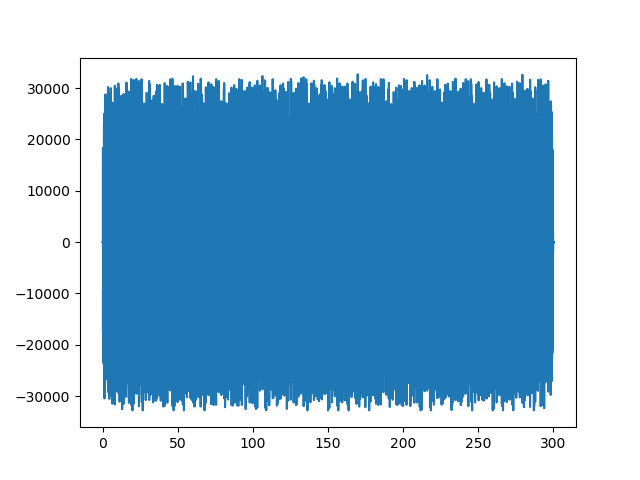

In [175]:
fig, ax = plt.subplots()

sampling_rate = 44100
time = np.arange(len(audio_data)) / sampling_rate

ax.plot(time[::100], audio_data[::100]) # plot every 100th point in the waveform

<IPython.core.display.Javascript object>


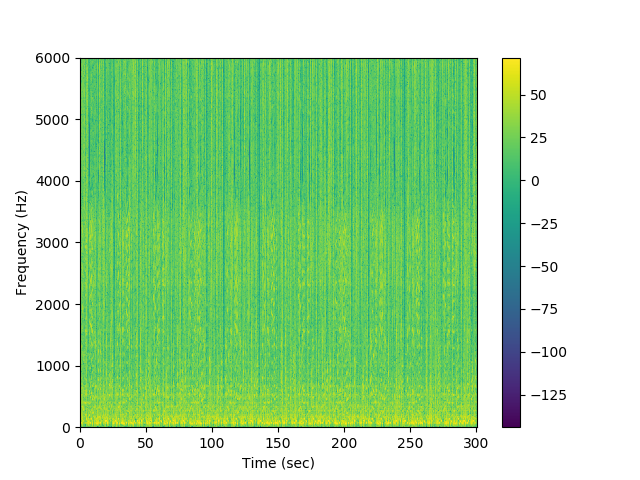

/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7564: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


In [176]:
fig, ax = plt.subplots()

S, freqs, times, im = ax.specgram(audio_data, NFFT=4096, Fs=sampling_rate,
                                  window=mlab.window_hanning,
                                  noverlap=4096 // 2)
fig.colorbar(im)

ax.set_xlabel("Time (sec)")
ax.set_ylabel("Frequency (Hz)")
ax.set_ylim(0, 6000);

In [177]:
def spectrogram_to_cutoff(spectrogram, frac_cut = 0.9):
    """ Given the values of a spectrogram, return the cutoff value that 
        distinguishes the foreground from the background.
        
        Parameters
        ----------
        spectrogram : numpy.ndarray, shape = (N, M)
            2D array of shape (N, M)
            
        frac_cut : int
            the percentage of lower amplitudes that will be considered 
            background
            
        Returns
        -------
        The cutoff value used to distinguish the foreground from the 
        background. """
        
    #spectrogram[spectrogram <= 0] = 1e-15
    spectrogram += 1e-20
    
    flat_spec = np.log(spectrogram.flatten())
    N = len(flat_spec)
    
    bin_counts, bin_edges = np.histogram(flat_spec, bins = int(N / 2), density = True)
    bin_size = np.diff(bin_edges)
    
    cumulative_distr = np.cumsum(bin_counts * bin_size)
    
    bin_index_of_cutoff = np.searchsorted(cumulative_distr, frac_cut)
    
    # given the bin-index, we want the associated log-amplitude value for that bin
    cutoff = bin_edges[bin_index_of_cutoff]
    return cutoff

In [178]:
audio_cutoff = spectrogram_to_cutoff(S)
print(audio_cutoff)

6.50163432858


In [179]:
def spectrogram_to_peaks(spectrogram, cutoff, iterations = 3):
    """ Given a spectrogram, return its peaks, which are all local peaks
        with values greater than the cutoff. 
        
        Parameters
        ----------
        spectrogram : numpy.ndarray, shape = (N, M)
            2D array of shape (N, M)
            
        cutoff : float
            elements less than or equal to the cutoff are considered 
            background elements
            
        iterations : int
            the number of iterations for the iterated footprint
            
        Returns
        -------
        A bool array of the peaks of a spectrogram. """
    
    fp = generate_binary_structure(rank = 2, connectivity = 1)
    spec_max = maximum_filter(spectrogram, footprint = iterate_structure(fp, iterations))
    return (spectrogram == spec_max) & (spectrogram > cutoff)

In [180]:
peaks = spectrogram_to_peaks(S, audio_cutoff)
print(np.sum(peaks))

200461


In [10]:
T = len(audio_data) / 44100

N = len(audio_data)
max_k = (N // 2) + 1
F = max_k / T

<IPython.core.display.Javascript object>


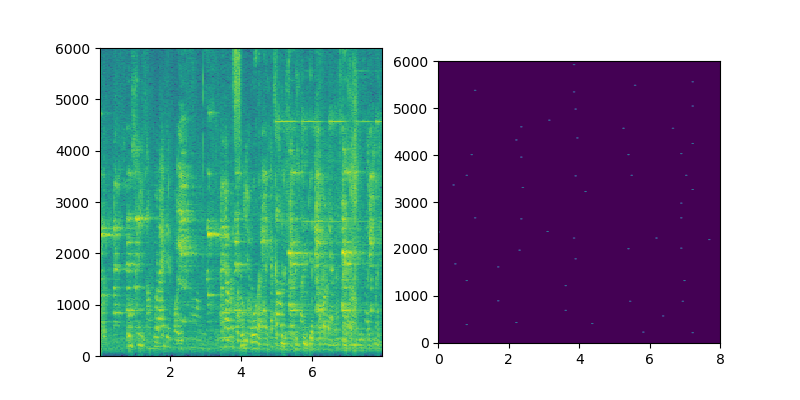

(0, 6000)

In [11]:
max_freq = 6000 # the largest frequency that we want to plot
extent = (0, T, 0, F)  # this is used to set the (left, right, bottom, top) scale for the image axes
aspect_ratio = T/max_freq


fig, axes = plt.subplots(ncols = 2, figsize=(8,4))

S, freqs, times, im = axes[0].specgram(audio_data, NFFT=4096, Fs=sampling_rate,
                                       window=mlab.window_hanning,
                                       noverlap=4096 // 2)

axes[0].set_ylim(0, 6000);

axes[1].imshow(peaks, origin="lower", aspect=aspect_ratio, extent=extent, interpolation="bilinear")
axes[1].set_ylim(0, max_freq)